In [46]:
import pandas as pd
import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
import utils
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from scipy.stats import ranksums
import matplotlib.pyplot as plt



In [2]:
### utilities here (move to new file eventually)
column_sums=pd.read_csv('column_sums.csv')
column_sums.set_index('Unnamed: 0', inplace=True)

class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 20)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(20, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class LogNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogNN, self).__init__()
        self.fc1 = nn.Linear(input_size, num_classes)


    def forward(self, x):
        out = self.fc1(x)
        return out


def isDivis(N, p):
    if N % p == 0:
        return 1
    else:
        return 0
    
def isDivisp(N, p):
    if N % p == 0:
        return 1/p
    else:
        return 0
    

def addRand():
    return random.random()
    
def preprocess(df, addcond=False , addprimeord=False, addrecipp=False, addRandom=0, drawrand=False, column_sums=False):
    X=df.drop(columns=['rank'])
    y=df['rank']

    column_names=df.columns.to_list()[:-2]
    column_names=[int(item) for item in column_names]
    
    if addprimeord:      
        new_columns={}
        for value in column_names:
            column_name = f'isDivis_{value}'
            new_columns[column_name] = X['conductor'].apply(lambda N: isDivis(int(N), value))
        X = pd.concat([X, pd.DataFrame(new_columns)], axis=1)

    if addRandom>0:    
        new_columns={}  
        for value in range(addRandom):
            column_name = f'randval_{value}'
            new_columns[column_name] = X['conductor'].apply(lambda N: addRand())
        X = pd.concat([X, pd.DataFrame(new_columns)], axis=1)
    
    if drawrand:
        new_columns={}
        for value in column_names:
            column_name = f'isDivis_{value}'
            prob=column_sums.loc['isDivis_'+str(value)].values[0]
            new_columns[column_name] = np.random.choice([0, 1], size=X.shape[0], p=[1-prob, prob])
        X = pd.concat([X, pd.DataFrame(new_columns, index=X.index)], axis=1)


    if addrecipp:
        new_columns={}
        for value in column_names:
            column_name = f'isDivisp_{value}'
            new_columns[column_name] = X['conductor'].apply(lambda N: isDivisp(int(N), value))
        X = pd.concat([X, pd.DataFrame(new_columns)], axis=1)
    
    if not addcond:
        X=X.drop(columns=['conductor'])
    else:
        X['conductor']=np.log(X['conductor'])

    return X, y

def gettens(X, y, random_state=42, test_size=0.2, batch_size=32):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.long)

    #Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=test_size, random_state=random_state)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

def train(model, train_dataloader, input_size, num_classes, num_epochs=40, lr=0.001):
    # Instantiate the model, define the loss function and the optimizer
    model = model(input_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for inputs, labels in train_dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model


def evaluate_model_with_mcc(model, test_dataloader):
    model.eval()  # Set the model to evaluation mode

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute MCC
    mcc = matthews_corrcoef(all_labels, all_predictions)
    return mcc


In [3]:
path = r"../data_files/ecq_B_1000_all_one_per_iso_262143_524287_sample_80k.parquet"
df = utils.load_data(path)

Loaded the big dataset with 1000 a_p's and 80000 curves..


In [4]:
df1=df[(df['conductor']>= 400000)]
del df

In [5]:
df1

,2,3,5,7,11,13,17,19,23,29,...,7867,7873,7877,7879,7883,7901,7907,7919,conductor,rank
index,,,,,,,,,,,,,,,,,,,,,
2100582,0.0000,-0.2887,-0.2236,0.0000,0.0000,0.1387,0.4851,0.2294,0.4170,-0.5571,...,-0.1917,-0.9129,0.6648,0.4506,0.1126,0.5513,0.0112,-0.1124,485160,0
2077622,0.0000,0.0000,0.8944,-0.1890,0.4523,0.0000,0.1213,0.0000,-0.9383,-0.3714,...,-0.3495,-0.4283,-0.1690,-0.0225,-0.7771,-0.7425,-0.7647,-0.1011,479791,1
2033639,0.3536,0.0000,-0.4472,-0.3780,-0.6030,0.8321,0.2425,0.0000,-0.4170,-0.1857,...,-0.4510,0.7776,0.2366,0.0225,0.6533,0.0000,-0.6523,0.4944,469386,1
1848068,-0.7071,0.0000,0.0000,0.7559,-0.3015,-0.5547,0.2425,-0.1147,0.8341,0.9285,...,0.1466,-0.4846,0.9183,-0.5295,0.2196,-0.5906,-0.3318,0.0225,425277,1
2158368,0.0000,-0.2887,0.0000,0.0000,-0.3015,0.1387,0.7276,0.5735,0.6255,0.0000,...,-0.4453,-0.1409,0.1014,-0.2929,0.0788,0.7425,0.1125,-0.2697,498624,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846446,0.3536,-0.2887,0.2236,0.1890,0.1508,0.5547,0.9701,0.5735,-0.1043,0.4642,...,0.7216,0.5297,0.1859,-0.1972,-0.0338,-0.8325,-0.4892,0.3371,424886,1
2126163,-0.3536,-0.5774,0.0000,-0.1890,-0.9045,0.0000,-0.2425,0.4588,0.1043,-0.1857,...,-0.2931,0.5748,0.7098,0.4281,0.4167,-0.2025,-0.7872,0.1011,491050,1
1927411,0.7071,0.5774,-0.6708,0.7559,-0.1508,0.8321,0.3638,-0.2294,-0.8341,-0.3714,...,-0.3495,0.5297,-0.1746,0.1465,-0.1295,-0.0225,0.7422,0.7023,444103,1


#### First, run a logistic regression model just with the first 1000 ap coefficients, then one with the first 1000 ap's as well as information on prime divisors, then one where the prime divisors are sampled at random based on the probability distribution of the dataset

In [6]:
### set up parameters for just the first 1000 columns
addcond=False
addprimeord=False
model=LogNN
drawrand=False

X, y = preprocess(df1, addcond=addcond, addprimeord=addprimeord, drawrand=drawrand, column_sums=column_sums)
input_size = X.shape[1]
print(X.shape)

#print((X.iloc[:, -1000:].sum(axis=0)/X.shape[0]).head(25))
#print(column_sums.head(25))

mcc_1000aps_log=[]
for i in range(100):     
    num_classes = len(y.unique())
    train_dataloader, test_dataloader = gettens(X, y, random_state=i)
    model = train(LogNN, train_dataloader, input_size, num_classes)
    mcc = evaluate_model_with_mcc(model, test_dataloader)
    mcc_1000aps.append(mcc)


(33596, 1000)


In [7]:
### set up parameters for the first 1000 ap values + random prime divisor data
addcond=False
addprimeord=False
model=LogNN
drawrand=True

X, y = preprocess(df1, addcond=addcond, addprimeord=addprimeord, drawrand=drawrand, column_sums=column_sums)
input_size = X.shape[1]
print(X.shape)

#print((X.iloc[:, -1000:].sum(axis=0)/X.shape[0]).head(25))
#print(column_sums.head(25))

mcc_with_rand_primes_log=[]
for i in range(100):     
    num_classes = len(y.unique())
    train_dataloader, test_dataloader = gettens(X, y, random_state=i)
    model = train(LogNN, train_dataloader, input_size, num_classes)
    mcc = evaluate_model_with_mcc(model, test_dataloader)
    mcc_with_rand_primes.append(mcc)


(33596, 2000)


In [8]:
### set up parameters for a model with the first 1000 ap values + prime divisors
addcond=False
addprimeord=True
model=LogNN
drawrand=False

X, y = preprocess(df1, addcond=addcond, addprimeord=addprimeord, drawrand=drawrand, column_sums=column_sums)
input_size = X.shape[1]
print(X.shape)

#print((X.iloc[:, -1000:].sum(axis=0)/X.shape[0]).head(25))
#print(column_sums.head(25))


mcc_with_prime_divs_log=[]
for i in range(100):     
    num_classes = len(y.unique())
    train_dataloader, test_dataloader = gettens(X, y, random_state=i)
    model = train(LogNN, train_dataloader, input_size, num_classes)
    mcc = evaluate_model_with_mcc(model, test_dataloader)
    mcc_with_prime_divs.append(mcc)

(33596, 2000)


Run A/B testing on the pairs (1000 ap's, 1000 ap's + random prime divisors) and (1000 ap's + random prime divisors, 1000 ap's + prime divisor data)

In [9]:
print(f"The mean MCC for 100 trials of the 1000 ap values using logistic regression is: {np.mean(mcc_1000aps_log)} and standard deviation {np.std(mcc_1000aps_log)}")
print(f"The mean MCC for 100 trials of the 1000 ap values plus random prime divisor data using logistic regression is: {np.mean(mcc_with_rand_primes_log)} and standard deviation {np.std(mcc_with_rand_primes_log)}")
print(f"The mean MCC for 100 trials of the 1000 ap values plus correct divisor data using logistic regression is: {np.mean(mcc_with_prime_divs_log)} and standard deviation {np.std(mcc_with_prime_divs_log)}")

The mean MCC for 100 trials of the 1000 ap values using logistic regression is: 0.7934717858038397 and standard deviation 0.005626594809459237
The mean MCC for 100 trials of the 1000 ap values plus random prime divisor data using logistic regression is: 0.7761680498152103 and standard deviation 0.00637751709520485
The mean MCC for 100 trials of the 1000 ap values plus correct divisor data using logistic regression is: 0.7845430886681081 and standard deviation 0.0067933702176117845


Visualize the distributions.

In [ ]:
bins = 10

# Plot histograms
plt.hist(mcc_1000aps_log, bins=bins, alpha=0.5, label='1000 aps')
plt.hist(mcc_with_rand_primes_log, bins=bins, alpha=0.5, label='Random prime divisors')
plt.hist(mcc_with_prime_divs_log, bins=bins, alpha=0.5, label='Correct prime divisors')

# Adding titles and labels
plt.title('Histograms of Multiple Data Sets')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Adding a legend
plt.legend(loc='upper right')

# Show plot
plt.show()

In [10]:
shapiro_test_1000aps_log = stats.shapiro(mcc_1000aps_log)
shapiro_test_rand_primes_log = stats.shapiro(mcc_with_rand_primes_log)
shapiro_test_prime_divs_log = stats.shapiro(mcc_with_prime_divs_log)

print("Shapiro-Wilk test results:")
print(f"mcc_1000aps_log: {shapiro_test_1000aps_log}")
print(f"mcc_with_rand_primes_log: {shapiro_test_rand_primes_log}")
print(f"mcc_with_prime_divs_log: {shapiro_test_prime_divs_log}")

Shapiro-Wilk test results:
mcc_1000aps: ShapiroResult(statistic=0.9804193893647213, pvalue=0.14329885109885293)
mcc_with_rand_primes: ShapiroResult(statistic=0.9887944527858573, pvalue=0.5684884399758537)
mcc_with_prime_divs: ShapiroResult(statistic=0.9912539498837079, pvalue=0.7649310939691585)


In [12]:
# Perform T-test if data is normally distributed, and a non-parametric test otherwise.
alpha = 0.05

if shapiro_test_1000aps_log.pvalue > 0.05 and shapiro_test_rand_primes_log.pvalue > 0.05:
    print("Data is normally distributed. Using a t-test to determine if there is a significant difference between using just 1000 ap values and adding random prime divisor data.")
    t_stat_log, p_value_log = stats.ttest_ind(mcc_1000aps_log, mcc_with_rand_primes_log)
    print(f"T-test result (mcc_1000aps_lpg vs mcc_with_rand_primes_log):")
    print(f'T-statistic: {t_stat_log}')
    print(f'P-value: {p_value_log}')
    if p_value_log < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two lists.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two lists.")
else:
    print("Data is not normally distributed. Using a non-parametric test (the Wilcoxon rank-sum test) to determine if there is a significant difference between using just 1000 ap values and adding random prime divisor data.")
    rank_stat, rank_p_value = ranksums(mcc_1000aps_log, mcc_with_rand_primes_log)
    if rank_p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two lists.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two lists.")
    

if shapiro_test_1000aps_log.pvalue > 0.05 and shapiro_test_prime_divs_log.pvalue > 0.05:
    print("Data is normally distributed. Using a t-test to determine if there is a significant difference between using just 1000 ap values and adding correct prime divisor data..")
    t_stat_log, p_value_log = stats.ttest_ind(mcc_1000aps_log, mcc_with_prime_divs_log)
    print(f"T-test result (mcc_1000aps vs mcc_with_prime_divs):")
    print(f'T-statistic: {t_stat_log}')
    print(f'P-value: {p_value_log}')
    if p_value_log < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two lists.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two lists.")
else:
    print("Data is not normally distributed. Using a non-parametric test (the Wilcoxon rank-sum test) to determine if there is a significant difference between using just 1000 ap values and adding correct prime divisor data.")
    rank_stat, rank_p_value = ranksums(mcc_1000aps_log, mcc_with_prime_divs_log)
    if rank_p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two lists.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two lists.")
    


if shapiro_test_1000aps_log.pvalue > 0.05 and shapiro_test_prime_divs_log.pvalue > 0.05:
    print("Data is normally distributed. Using a t-test to determine if there is a significant difference between using randomand correct prime divisor data.")
    t_stat_log, p_value_log = stats.ttest_ind(mcc_with_rand_primes_log, mcc_with_prime_divs_log)
    print(f"T-test result (mcc_with_rand_primes vs mcc_with_prime_divs):")
    print(f'T-statistic: {t_stat_log}')
    print(f'P-value: {p_value_log}')
    if p_value_log < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two lists.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two lists.")
else:
    print("Data is not normally distributed. Using a non-parametric test (the Wilcoxon rank-sum test) to determine if there is a significant difference between using randomand correct prime divisor data.")
    rank_stat, rank_p_value = ranksums(mcc_with_rand_primes_log, mcc_with_prime_divs_log)
    if rank_p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two lists.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two lists.")

Shapiro-Wilk test results:
mcc_1000aps: ShapiroResult(statistic=0.9804193893647213, pvalue=0.14329885109885293)
mcc_with_rand_primes: ShapiroResult(statistic=0.9887944527858573, pvalue=0.5684884399758537)
mcc_with_prime_divs: ShapiroResult(statistic=0.9912539498837079, pvalue=0.7649310939691585)
T-test result (mcc_1000aps vs mcc_with_rand_primes):
T-statistic: 20.243908322157253
P-value: 4.1118134135781107e-50
Reject the null hypothesis: There is a significant difference between the two lists.
T-test result (mcc_1000aps vs mcc_with_prime_divs):
T-statistic: 10.07145722451518
P-value: 1.5848358087218002e-19
Reject the null hypothesis: There is a significant difference between the two lists.
T-test result (mcc_with_rand_primes vs mcc_with_prime_divs):
T-statistic: -8.94309874764402
P-value: 2.6978714931505945e-16
Reject the null hypothesis: There is a significant difference between the two lists.


#### Next, do the same, now running a simple neural network

In [15]:
### set up parameters for just the first 1000 columns
addcond=False
addprimeord=False
model=LogNN
drawrand=False

X, y = preprocess(df1, addcond=addcond, addprimeord=addprimeord, drawrand=drawrand, column_sums=column_sums)
input_size = X.shape[1]
print(X.shape)

#print((X.iloc[:, -1000:].sum(axis=0)/X.shape[0]).head(25))
#print(column_sums.head(25))

mcc_1000aps_NN=[]
for i in range(100):     
    num_classes = len(y.unique())
    train_dataloader, test_dataloader = gettens(X, y, random_state=i)
    model = train(SimpleNN, train_dataloader, input_size, num_classes)
    mcc = evaluate_model_with_mcc(model, test_dataloader)
    mcc_1000aps_NN.append(mcc)


(33596, 1000)


In [16]:
### set up parameters for the first 1000 ap values + random prime divisor data
addcond=False
addprimeord=False
model=LogNN
drawrand=True

X, y = preprocess(df1, addcond=addcond, addprimeord=addprimeord, drawrand=drawrand, column_sums=column_sums)
input_size = X.shape[1]
print(X.shape)

#print((X.iloc[:, -1000:].sum(axis=0)/X.shape[0]).head(25))
#print(column_sums.head(25))

mcc_with_rand_primes_NN=[]
for i in range(100):     
    num_classes = len(y.unique())
    train_dataloader, test_dataloader = gettens(X, y, random_state=i)
    model = train(SimpleNN, train_dataloader, input_size, num_classes)
    mcc = evaluate_model_with_mcc(model, test_dataloader)
    mcc_with_rand_primes_NN.append(mcc)

(33596, 2000)


In [17]:
### set up parameters for a model with the first 1000 ap values + prime divisors
addcond=False
addprimeord=True
model=LogNN
drawrand=False

X, y = preprocess(df1, addcond=addcond, addprimeord=addprimeord, drawrand=drawrand, column_sums=column_sums)
input_size = X.shape[1]
print(X.shape)

#print((X.iloc[:, -1000:].sum(axis=0)/X.shape[0]).head(25))
#print(column_sums.head(25))


mcc_with_prime_divs_NN=[]
for i in range(100):     
    num_classes = len(y.unique())
    train_dataloader, test_dataloader = gettens(X, y, random_state=i)
    model = train(SimpleNN, train_dataloader, input_size, num_classes)
    mcc = evaluate_model_with_mcc(model, test_dataloader)
    mcc_with_prime_divs_NN.append(mcc)

(33596, 2000)


In [39]:
print(f"The mean MCC for 100 trials of the 1000 ap values using logistic regression is: {np.mean(mcc_1000aps_NN)} and standard deviation {np.std(mcc_1000aps_NN)}")
print(f"The mean MCC for 100 trials of the 1000 ap values plus random prime divisor data using logistic regression is: {np.mean(mcc_with_rand_primes_NN)} and standard deviation {np.std(mcc_with_rand_primes_NN)}")
print(f"The mean MCC for 100 trials of the 1000 ap values plus correct divisor data using logistic regression is: {np.mean(mcc_with_prime_divs_NN)} and standard deviation {np.std(mcc_with_prime_divs_NN)}")

The mean MCC for 100 trials of the 1000 ap values using logistic regression is: 0.8016059854358448 and standard deviation 0.011264933723214781
The mean MCC for 100 trials of the 1000 ap values plus random prime divisor data using logistic regression is: 0.8027217885961724 and standard deviation 0.012765710143521033
The mean MCC for 100 trials of the 1000 ap values plus correct divisor data using logistic regression is: 0.8166112703742996 and standard deviation 0.01065341380609778


Visualize the distributions

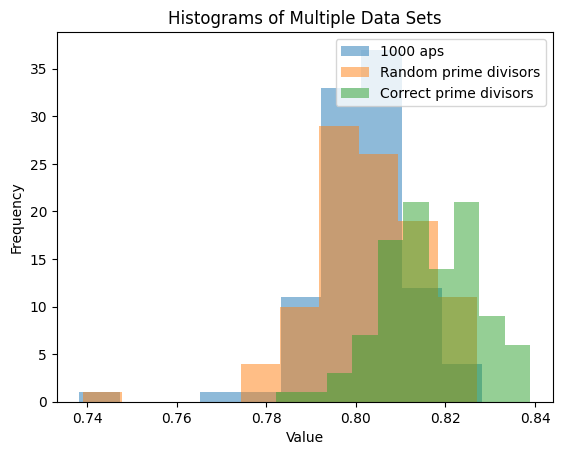

In [50]:
bins = 10

# Plot histograms
plt.hist(mcc_1000aps_NN, bins=bins, alpha=0.5, label='1000 aps')
plt.hist(mcc_with_rand_primes_NN, bins=bins, alpha=0.5, label='Random prime divisors')
plt.hist(mcc_with_prime_divs_NN, bins=bins, alpha=0.5, label='Correct prime divisors')

# Adding titles and labels
plt.title('Histograms of Multiple Data Sets')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Adding a legend
plt.legend(loc='upper right')

# Show plot
plt.show()

In [40]:
shapiro_test_1000aps_NN = stats.shapiro(mcc_1000aps_NN)
shapiro_test_rand_primes_NN = stats.shapiro(mcc_with_rand_primes_NN)
shapiro_test_prime_divs_NN = stats.shapiro(mcc_with_prime_divs_NN)

print("Shapiro-Wilk test results:")
print(f"mcc_1000aps: {shapiro_test_1000aps_NN}")
print(f"mcc_with_rand_primes: {shapiro_test_rand_primes_NN}")
print(f"mcc_with_prime_divs: {shapiro_test_prime_divs_NN}")

Shapiro-Wilk test results:
mcc_1000aps: ShapiroResult(statistic=0.8838135027660748, pvalue=2.6410047100518967e-07)
mcc_with_rand_primes: ShapiroResult(statistic=0.9240774909642739, pvalue=2.3316166489628912e-05)
mcc_with_prime_divs: ShapiroResult(statistic=0.9854273020743147, pvalue=0.34078198972033963)


In [49]:
# Perform T-test if data is normally distributed
alpha = 0.05

if shapiro_test_1000aps_NN.pvalue > 0.05 and shapiro_test_rand_primes_NN.pvalue > 0.05:
    print("Data is normally distributed. Using a t-test to determine if there is a significant difference between using just 1000 ap values and adding random prime divisor data.")
    t_stat_NN, p_value_NN = stats.ttest_ind(mcc_1000aps_NN, mcc_with_rand_primes_NN)
    print(f"T-test result (mcc_1000aps_lpg vs mcc_with_rand_primes_NN):")
    print(f'T-statistic: {t_stat_NN}')
    print(f'P-value: {p_value_NN}')
    if p_value_NN < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two lists.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two lists.")
else:
    print("Data is not normally distributed. Using a non-parametric test (the Wilcoxon rank-sum test) to determine if there is a significant difference between using just 1000 ap values and adding random prime divisor data.")
    rank_stat, rank_p_value = ranksums(mcc_1000aps_NN, mcc_with_rand_primes_NN)
    if rank_p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two lists.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two lists.")
    

if shapiro_test_1000aps_NN.pvalue > 0.05 and shapiro_test_prime_divs_NN.pvalue > 0.05:
    print("Data is normally distributed. Using a t-test to determine if there is a significant difference between using just 1000 ap values and adding correct prime divisor data..")
    t_stat_NN, p_value_NN = stats.ttest_ind(mcc_1000aps_NN, mcc_with_prime_divs_NN)
    print(f"T-test result (mcc_1000aps vs mcc_with_prime_divs):")
    print(f'T-statistic: {t_stat_NN}')
    print(f'P-value: {p_value_NN}')
    if p_value_NN < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two lists.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two lists.")
else:
    print("Data is not normally distributed. Using a non-parametric test (the Wilcoxon rank-sum test) to determine if there is a significant difference between using just 1000 ap values and adding correct prime divisor data.")
    rank_stat, rank_p_value = ranksums(mcc_1000aps_NN, mcc_with_prime_divs_NN)
    if rank_p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two lists.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two lists.")
    


if shapiro_test_1000aps_NN.pvalue > 0.05 and shapiro_test_prime_divs_NN.pvalue > 0.05:
    print("Data is normally distributed. Using a t-test to determine if there is a significant difference between using randomand correct prime divisor data.")
    t_stat_NN, p_value_NN = stats.ttest_ind(mcc_with_rand_primes_NN, mcc_with_prime_divs_NN)
    print(f"T-test result (mcc_with_rand_primes vs mcc_with_prime_divs):")
    print(f'T-statistic: {t_stat_NN}')
    print(f'P-value: {p_value_NN}')
    if p_value_NN < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two lists.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two lists.")
else:
    print("Data is not normally distributed. Using a non-parametric test (the Wilcoxon rank-sum test) to determine if there is a significant difference between using randomand correct prime divisor data.")
    rank_stat, rank_p_value = ranksums(mcc_with_rand_primes_NN, mcc_with_prime_divs_NN)
    if rank_p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two lists.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two lists.")
    

Data is not normally distributed. Using a non-parametric test (the Wilcoxon rank-sum test) to determine if there is a significant difference between using just 1000 ap values and adding random prime divisor data.
Fail to reject the null hypothesis: There is no significant difference between the two lists.
Data is not normally distributed. Using a non-parametric test (the Wilcoxon rank-sum test) to determine if there is a significant difference between using just 1000 ap values and adding correct prime divisor data.
Reject the null hypothesis: There is a significant difference between the two lists.
Data is not normally distributed. Using a non-parametric test (the Wilcoxon rank-sum test) to determine if there is a significant difference between using randomand correct prime divisor data.
Reject the null hypothesis: There is a significant difference between the two lists.
